In [1]:
import pandas as pa
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from ortools.graph import pywrapgraph
import random
import plotly.graph_objects as go
from ipywidgets import interact, IntSlider, FloatSlider

def print_info(data, name):
    if isinstance(data, list):
        print(' % ', name, ' ', data, ' -----type $len: ', len(data), ' ', type(data), ' * ')
    else:
        print(' % ', name, ' ', data, ' -----type ', type(data), ' * ')

def setup(districts, grid_size, district_centers, pops): 
    tol = 1
    start_nodes = [0] * (grid_size * grid_size)
    for i in range(grid_size * grid_size):
        start_nodes = start_nodes + [i + 1] * districts
    for j in range(districts):
        start_nodes = start_nodes + [(grid_size * grid_size) + 1 + j]
    end_nodes = []
    for i in range(grid_size * grid_size):
        end_nodes = end_nodes + [i + 1]
    for j in range(grid_size * grid_size):
        for k in range(districts):
            end_nodes = end_nodes + [(grid_size * grid_size) + 1 + k]
    end_nodes = end_nodes + [(grid_size * grid_size) + districts + 1] * districts
    total_pop = np.sum(np.array(pops))
    capacities = np.array(pops).flatten().tolist()
    for i in np.array(pops).flatten().tolist():
        for j in range(districts):
            capacities = capacities + [i]
    for i in range(districts):
        capacities = capacities + [int(total_pop / districts) + tol]
    costs = [0] * (grid_size * grid_size)
    for i in range(grid_size):
        for j in range(grid_size):
            for k in range(districts):
                costs = costs + [int((((i - district_centers[k][0]) ** 2) + ((j - district_centers[k][1]) ** 2)))]
    costs = costs + [0] * districts
    supplies = [int(total_pop)] + ((grid_size * grid_size) + districts) * [0] + [-int(total_pop)]
    source = 0
    sink = districts + (grid_size * grid_size) + 1
    return start_nodes, end_nodes, capacities, costs, supplies, source, sink, pops, total_pop

def optimize(start_nodes, end_nodes, capacities, costs, supplies, source, sink, grid, grid_size):
    Block_Assignments = pa.DataFrame(columns=['DIST_NO', 'ASSIGN_POP', 'ACTUAL_POP'])
    min_cost_flow = pywrapgraph.SimpleMinCostFlow()
    for i in range(len(start_nodes)):
        min_cost_flow.AddArcWithCapacityAndUnitCost(start_nodes[i], end_nodes[i], capacities[i], costs[i])
    for i in range(len(supplies)):
        min_cost_flow.SetNodeSupply(i, supplies[i])
    flag = 0    
    if min_cost_flow.Solve() == min_cost_flow.OPTIMAL:
        for arc in range(min_cost_flow.NumArcs()):
            if min_cost_flow.Tail(arc) != source and min_cost_flow.Head(arc) != sink:
                if min_cost_flow.Flow(arc) > 0:
                    if min_cost_flow.Capacity(arc) == min_cost_flow.Flow(arc):
                        grid.nodes[(int(((min_cost_flow.Tail(arc) - 1) / grid_size)), (min_cost_flow.Tail(arc) - 1) % grid_size)]["district"] = min_cost_flow.Head(arc)
                        Block_Assignments.loc[min_cost_flow.Tail(arc)] = [min_cost_flow.Head(arc), min_cost_flow.Flow(arc), min_cost_flow.Capacity(arc)]
                    else:
                        if flag == 0:
                            grid.nodes[(int(((min_cost_flow.Tail(arc) - 1) / grid_size)), (min_cost_flow.Tail(arc) - 1) % grid_size)]["district"] = min_cost_flow.Head(arc)
                            Block_Assignments.loc[min_cost_flow.Tail(arc)] = [min_cost_flow.Head(arc), min_cost_flow.Flow(arc), min_cost_flow.Capacity(arc)]
                            flag = min_cost_flow.Flow(arc)
                        else: 
                            if Block_Assignments.loc[min_cost_flow.Tail(arc), 'ASSIGN_POP'] < min_cost_flow.Flow(arc):
                                grid.nodes[(int(((min_cost_flow.Tail(arc) - 1) / grid_size)), (min_cost_flow.Tail(arc) - 1) % grid_size)]["district"] = min_cost_flow.Head(arc)
                                Block_Assignments.loc[min_cost_flow.Tail(arc)] = [min_cost_flow.Head(arc), min_cost_flow.Flow(arc), min_cost_flow.Capacity(arc)]
                                flag = flag + min_cost_flow.Flow(arc)
                            else:
                                flag = flag + min_cost_flow.Flow(arc)
                            if flag == min_cost_flow.Capacity(arc):
                                flag = 0
    else:
        print('There was an issue with the min cost flow input.')
    return Block_Assignments

def grid_setup(grid_s, dist, n, p_0, c, r):
    

    grid_size = grid_s
    districts = dist
    district_centers = []
    spacing = int(grid_size / districts)
    

    for j in range(districts):
        district_centers = district_centers + [[(j + 1) * spacing + random.randint(-1, 1), random.randint(0, grid_size - 1)]]
    pops = []
    row = []    
    

    for i in range(grid_size):
        for j in range(grid_size):
            row = row + [1]
        pops = pops + [row]
        row = []
    grid = nx.grid_graph([grid_size, grid_size])
    

    for node in grid.nodes():
        grid.nodes[node]["population"] = pops[node[0]][node[1]]
    

    add_party_preference(grid, n, grid_size, p_0, c, r)
    return districts, grid_size, district_centers, pops, grid

def add_party_preference(grid, n, grid_size, p_0, c, r):
    squares_with_id = []
    all_nodes = list(grid.nodes())
    all_nodes_processed = []
    voter_arr_ind = 0
    row_tracker = 0
    square = []
    voter_arr_ind = 0
    m_val_holder = 0
    vertical_mover = 0
    for i in range(n):
        if i != 0:
            vertical_mover += r * grid_size
        for m in range(n):
            row_tracker = (c * m) + vertical_mover
            square = []            
            for j in range(r):
                row = all_nodes[row_tracker:row_tracker + c]
                square = square + row
                row_tracker += grid_size
            all_nodes_processed += square
            voter_ratios = np.ones(c * r)
            proportion_of_a = math.floor((c * r) * p_0)
            voter_ratios[:proportion_of_a] = 0
            np.random.shuffle(voter_ratios)
            for node in square:    
                grid.nodes[node]['voter_pref'] = voter_ratios[voter_arr_ind]
                voter_arr_ind = voter_arr_ind + 1
            squares_with_id.append(square)       
            voter_arr_ind = 0
            square = []
    missed_nodes = list(set(all_nodes).difference(all_nodes_processed))
    if missed_nodes:   
        print("missed_nodes = " + str(missed_nodes))

def interactive_plot(grid_size, districts, p_0, c, r, n):
    try:

        districts, grid_size, district_centers, pops, grid = grid_setup(grid_size, districts, n, p_0, c, r)

        start_nodes, end_nodes, capacities, costs, supplies, source, sink, pops, total_pop = setup(districts, grid_size, district_centers, pops)

        Block_Assignments = optimize(start_nodes, end_nodes, capacities, costs, supplies, source, sink, grid, grid_size)
        

        x_coords = []
        y_coords = []
        colors = []
        districts_list = []

        for node in grid.nodes():
            x, y = node
            x_coords.append(x)
            y_coords.append(y)
            district = grid.nodes[node]["district"]
            districts_list.append(district)
            
            color = 'blue' if grid.nodes[node]['voter_pref'] == 0 else 'red'
            colors.append(color)

        fig = go.Figure()
        for i in range(len(x_coords)):
            fig.add_trace(go.Scatter(x=[x_coords[i]], y=[y_coords[i]], mode='markers', marker=dict(color=colors[i]), name=f'District {districts_list[i]}'))

        fig.update_layout(title='District Map', xaxis_title='X', yaxis_title='Y')
        fig.show()

    except Exception as e:
        print(f"Error in interactive_plot function: {e}")

interact(interactive_plot, grid_size=IntSlider(min=5, max=20, step=1, value=10),
         districts=IntSlider(min=2, max=10, step=1, value=5),
         p_0=FloatSlider(min=0.1, max=0.9, step=0.1, value=0.5),
         c=IntSlider(min=1, max=10, step=1, value=3),
         r=IntSlider(min=1, max=10, step=1, value=3),
         n=IntSlider(min=1, max=10, step=1, value=5))


interactive(children=(IntSlider(value=10, description='grid_size', max=20, min=5), IntSlider(value=5, descript…

<function __main__.interactive_plot(grid_size, districts, p_0, c, r, n)>

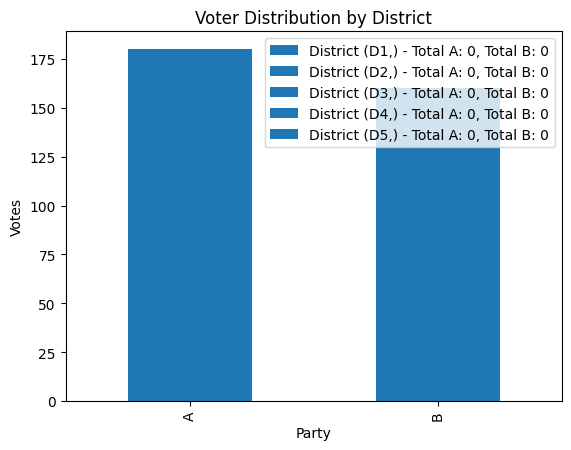

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample data for demonstration
data = {
    'Party': ['A', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 'B'],
    'Votes': [100, 80, 150, 130, 120, 110, 160, 140, 180, 160],
    'District': ['D1', 'D1', 'D2', 'D2', 'D3', 'D3', 'D4', 'D4', 'D5', 'D5']
}

df = pd.DataFrame(data)

# Calculate the total votes for each party
total_votes = df.groupby('Party')['Votes'].sum()

# Plotting the voter distribution
fig, ax = plt.subplots()

for key, grp in df.groupby(['District']):
    ax = grp.plot(ax=ax, kind='bar', x='Party', y='Votes', label=key)

# Creating custom legend
handles, labels = ax.get_legend_handles_labels()
legend_labels = [f"District {label} - Total A: {df[df['District']==label].loc[df['Party']=='A', 'Votes'].sum()}, Total B: {df[df['District']==label].loc[df['Party']=='B', 'Votes'].sum()}" for label in labels]

plt.legend(handles, legend_labels)
plt.title("Voter Distribution by District")
plt.xlabel("Party")
plt.ylabel("Votes")
plt.show()


In [2]:
import pandas as pd
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from ortools.graph import pywrapgraph
import random
import plotly.graph_objects as go
from ipywidgets import interact, IntSlider, FloatSlider

def print_info(data, name):
    if isinstance(data, list):
        print(' % ', name, ' ', data, ' -----type $len: ', len(data), ' ', type(data), ' * ')
    else:
        print(' % ', name, ' ', data, ' -----type ', type(data), ' * ')

def setup(districts, grid_size, district_centers, pops): 
    tol = 1
    start_nodes = [0] * (grid_size * grid_size)
    for i in range(grid_size * grid_size):
        start_nodes = start_nodes + [i + 1] * districts
    for j in range(districts):
        start_nodes = start_nodes + [(grid_size * grid_size) + 1 + j]
    end_nodes = []
    for i in range(grid_size * grid_size):
        end_nodes = end_nodes + [i + 1]
    for j in range(grid_size * grid_size):
        for k in range(districts):
            end_nodes = end_nodes + [(grid_size * grid_size) + 1 + k]
    end_nodes = end_nodes + [(grid_size * grid_size) + districts + 1] * districts
    total_pop = np.sum(np.array(pops))
    capacities = np.array(pops).flatten().tolist()
    for i in np.array(pops).flatten().tolist():
        for j in range(districts):
            capacities = capacities + [i]
    for i in range(districts):
        capacities = capacities + [int(total_pop / districts) + tol]
    costs = [0] * (grid_size * grid_size)
    for i in range(grid_size):
        for j in range(grid_size):
            for k in range(districts):
                costs = costs + [int((((i - district_centers[k][0]) ** 2) + ((j - district_centers[k][1]) ** 2)))]
    costs = costs + [0] * districts
    supplies = [int(total_pop)] + ((grid_size * grid_size) + districts) * [0] + [-int(total_pop)]
    source = 0
    sink = districts + (grid_size * grid_size) + 1
    return start_nodes, end_nodes, capacities, costs, supplies, source, sink, pops, total_pop

def optimize(start_nodes, end_nodes, capacities, costs, supplies, source, sink, grid, grid_size):
    Block_Assignments = pd.DataFrame(columns=['DIST_NO', 'ASSIGN_POP', 'ACTUAL_POP'])
    min_cost_flow = pywrapgraph.SimpleMinCostFlow()
    for i in range(len(start_nodes)):
        min_cost_flow.AddArcWithCapacityAndUnitCost(start_nodes[i], end_nodes[i], capacities[i], costs[i])
    for i in range(len(supplies)):
        min_cost_flow.SetNodeSupply(i, supplies[i])
    flag = 0    
    if min_cost_flow.Solve() == min_cost_flow.OPTIMAL:
        for arc in range(min_cost_flow.NumArcs()):
            if min_cost_flow.Tail(arc) != source and min_cost_flow.Head(arc) != sink:
                if min_cost_flow.Flow(arc) > 0:
                    if min_cost_flow.Capacity(arc) == min_cost_flow.Flow(arc):
                        grid.nodes[(int(((min_cost_flow.Tail(arc) - 1) / grid_size)), (min_cost_flow.Tail(arc) - 1) % grid_size)]["district"] = min_cost_flow.Head(arc)
                        Block_Assignments.loc[min_cost_flow.Tail(arc)] = [min_cost_flow.Head(arc), min_cost_flow.Flow(arc), min_cost_flow.Capacity(arc)]
                    else:
                        if flag == 0:
                            grid.nodes[(int(((min_cost_flow.Tail(arc) - 1) / grid_size)), (min_cost_flow.Tail(arc) - 1) % grid_size)]["district"] = min_cost_flow.Head(arc)
                            Block_Assignments.loc[min_cost_flow.Tail(arc)] = [min_cost_flow.Head(arc), min_cost_flow.Flow(arc), min_cost_flow.Capacity(arc)]
                            flag = min_cost_flow.Flow(arc)
                        else: 
                            if Block_Assignments.loc[min_cost_flow.Tail(arc), 'ASSIGN_POP'] < min_cost_flow.Flow(arc):
                                grid.nodes[(int(((min_cost_flow.Tail(arc) - 1) / grid_size)), (min_cost_flow.Tail(arc) - 1) % grid_size)]["district"] = min_cost_flow.Head(arc)
                                Block_Assignments.loc[min_cost_flow.Tail(arc)] = [min_cost_flow.Head(arc), min_cost_flow.Flow(arc), min_cost_flow.Capacity(arc)]
                                flag = flag + min_cost_flow.Flow(arc)
                            else:
                                flag = flag + min_cost_flow.Flow(arc)
                            if flag == min_cost_flow.Capacity(arc):
                                flag = 0
    else:
        print('There was an issue with the min cost flow input.')
    return Block_Assignments

def grid_setup(grid_s, dist, n, p_0, c, r):
    grid_size = grid_s
    districts = dist
    district_centers = []
    spacing = int(grid_size / districts)

    for j in range(districts):
        district_centers = district_centers + [[(j + 1) * spacing + random.randint(-1, 1), random.randint(0, grid_size - 1)]]
    pops = []
    row = []

    for i in range(grid_size):
        for j in range(grid_size):
            row = row + [1]
        pops = pops + [row]
        row = []
    grid = nx.grid_graph([grid_size, grid_size])

    for node in grid.nodes():
        grid.nodes[node]["population"] = pops[node[0]][node[1]]

    add_party_preference(grid, n, grid_size, p_0, c, r)
    return districts, grid_size, district_centers, pops, grid

def add_party_preference(grid, n, grid_size, p_0, c, r):
    squares_with_id = []
    all_nodes = list(grid.nodes())
    all_nodes_processed = []
    voter_arr_ind = 0
    row_tracker = 0
    square = []
    voter_arr_ind = 0
    m_val_holder = 0
    vertical_mover = 0
    for i in range(n):
        if i != 0:
            vertical_mover += r * grid_size
        for m in range(n):
            row_tracker = (c * m) + vertical_mover
            square = []            
            for j in range(r):
                row = all_nodes[row_tracker:row_tracker + c]
                square = square + row
                row_tracker += grid_size
            all_nodes_processed += square
            voter_ratios = np.ones(c * r)
            proportion_of_a = math.floor((c * r) * p_0)
            voter_ratios[:proportion_of_a] = 0
            np.random.shuffle(voter_ratios)
            for node in square:    
                grid.nodes[node]['voter_pref'] = voter_ratios[voter_arr_ind]
                voter_arr_ind = voter_arr_ind + 1
            squares_with_id.append(square)       
            voter_arr_ind = 0
            square = []
    missed_nodes = list(set(all_nodes).difference(all_nodes_processed))
    if missed_nodes:   
        print("missed_nodes = " + str(missed_nodes))

def interactive_plot(grid_size, districts, p_0, c, r, n):
    try:
        districts, grid_size, district_centers, pops, grid = grid_setup(grid_size, districts, n, p_0, c, r)

        start_nodes, end_nodes, capacities, costs, supplies, source, sink, pops, total_pop = setup(districts, grid_size, district_centers, pops)

        Block_Assignments = optimize(start_nodes, end_nodes, capacities, costs, supplies, source, sink, grid, grid_size)
        
        # Collect coordinates and colors for the grid
        x_coords = []
        y_coords = []
        colors = []
        districts_list = []

        for node in grid.nodes():
            x, y = node
            x_coords.append(x)
            y_coords.append(y)
            district = grid.nodes[node]["district"]
            districts_list.append(district)
            
            color = 'blue' if grid.nodes[node]['voter_pref'] == 0 else 'red'
            colors.append(color)

        # Calculate total votes for each party in each district
        total_a = []
        total_b = []

        for dist in range(1, districts + 1):
            dist_a = sum(grid.nodes[node]['voter_pref'] == 0 and grid.nodes[node]['district'] == dist for node in grid.nodes())
            dist_b = sum(grid.nodes[node]['voter_pref'] == 1 and grid.nodes[node]['district'] == dist for node in grid.nodes())
            total_a.append(dist_a)
            total_b.append(dist_b)

        # Plot with Plotly
        fig = go.Figure()

        for i in range(len(x_coords)):
            fig.add_trace(go.Scatter(
                            x=[x_coords[i]], 
                            y=[y_coords[i]], 
                            mode='markers', 
                            marker=dict(color=colors[i]), 
                            name=f'District {districts_list[i]}'
                        ))

            # Update the layout to include the custom legend
            fig.update_layout(
                title='District Map',
                xaxis_title='X',
                yaxis_title='Y',
                legend_title='Districts',
                showlegend=True
            )

        # Create custom legend entries
        for dist in range(1, districts + 1):
            fig.add_trace(go.Scatter(
                x=[None], 
                y=[None], 
                mode='markers', 
                marker=dict(color='blue'), 
                legendgroup=f'District {dist}',
                showlegend=True,
                name=f'District {dist} - Total A: {total_a[dist-1]}, Total B: {total_b[dist-1]}'
            ))

        fig.show()

    except Exception as e:
        print(f"Error in interactive_plot function: {e}")

interact(interactive_plot, grid_size=IntSlider(min=5, max=20, step=1, value=10),
         districts=IntSlider(min=2, max=10, step=1, value=5),
         p_0=FloatSlider(min=0.1, max=0.9, step=0.1, value=0.5),
         c=IntSlider(min=1, max=10, step=1, value=3),
         r=IntSlider(min=1, max=10, step=1, value=3),
         n=IntSlider(min=1, max=10, step=1, value=5))

interactive(children=(IntSlider(value=10, description='grid_size', max=20, min=5), IntSlider(value=5, descript…

<function __main__.interactive_plot(grid_size, districts, p_0, c, r, n)>